In [1]:
!pip install opencv-python
print('done')

     |████████████████████████████████| 28.7MB 8.8kB/s eta 0:00:01   |                                | 92kB 4.4MB/s eta 0:00:07            | 13.9MB 801kB/s eta 0:00:19     |███████████████████▌            | 17.4MB 1.6MB/s eta 0:00:08| 25.3MB 749kB/s eta 0:00:05     |████████████████████████████▋   | 25.6MB 749kB/s eta 0:00:05�██████████████▊  | 26.6MB 1.6MB/s eta 0:00:02��██████████████████████████▊ | 27.5MB 1.6MB/s eta 0:00:01ta 0:00:01
done


In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

banana_ar = np.load('banana_ar.npy')
orange_ar = np.load('orange_ar.npy')
lemon_ar = np.load('lemon_ar.npy')
banana_solidity = np.load('banana_solidity.npy')
orange_solidity = np.load('orange_solidity.npy')
lemon_solidity = np.load('lemon_solidity.npy')
banana_h = np.load('banana_h.npy')
orange_h = np.load('orange_h.npy')
lemon_h = np.load('lemon_h.npy')

print(banana_ar)
print('done')

[0.63616327 0.5437535  0.51904245 0.71013751 0.81561777 0.64513127
 0.50465533 1.         0.31642081 0.59588781 0.43239449 0.78888833
 0.53340608 0.73094359 0.66624679 0.61654259 0.17251204 0.84588788
 0.19979066 0.6017436 ]
done


In [8]:
#expectation maximization
inputs = np.array([[banana_ar, orange_ar, lemon_ar],
                   [banana_solidity, orange_solidity, lemon_solidity],
                   [banana_h, orange_h, lemon_h]]) #dim 3x3x20


def normal(x, mu, el):
    coeff = 1/(2*np.pi*np.linalg.norm(el))
    f = np.e**(-0.5*np.dot(x.T-mu, np.dot(np.linalg.inv(el), (x.T-mu).T)))
    return coeff*f

def G2D(x, mu, e):
    p = np.empty((len(x[0]), len(x[1])))
    for j in range(p.shape[0]):
        for i in range(p.shape[1]):
            a = np.array([x[0,i], x[1,j]]).reshape((2,1))
            p[j,i] = normal(a, mu, e)
    return p

def outputs(x,y,iterations):
    # initialize
    x,y = np.copy(x), np.copy(y)
    a = np.array([x,y]) #dim 2x3x20
    print(a.shape)
    mu = np.array([[np.random.choice(x[0]),np.random.choice(x[1]),np.random.choice(x[2])],
                   [np.random.choice(y[0]),np.random.choice(y[1]),np.random.choice(y[2])]]) #dim 2x3
#     e = np.array([[np.random.random(),np.random.random()],
#                   [np.random.random(),np.random.random()]])
#     E = np.array([e,e,e])
    E = np.array([[[0.9, 0.1],[0.1, 0.9]],
                  [[0.9, 0.1],[0.1, 0.9]], 
                  [[0.9, 0.1],[0.1, 0.9]]]) #dim 3x2x2
    Pl = np.ones((len(x), 1))/len(x) #dim 3x1
    pl = np.empty((len(x), len(x[0]), len(y[0]))) #dim 3x20x20
    
    if iterations > 0:
        while iterations > 0:
            # calc
            # calc pl
            pl[0,:,:] = G2D(a[:,0,:], mu[:,0], E[0])
            pl[1,:,:] = G2D(a[:,1,:], mu[:,1], E[1])
            pl[2,:,:] = G2D(a[:,2,:], mu[:,2], E[2])

            # calc P
            P = np.empty((len(x), len(x[0]))) #dim 3x20
            for l in range(len(x)):
                for i in range(len(x[0])):
                    P[l,i] = normal(a[:,l,i], mu[:,l], E[l])
                P[l,:] = Pl[l] * P[l,:]
            P = P/(P[0,:] + P[1,:] + P[2,:])

            # update
            # new_Pl
            new_Pl = np.sum(P, axis = 1)/P.shape[1]
            
            # new_mu
            new_mu = np.empty((2,3))
            for l in range(len(x)):
                new_mu[:,l] = np.dot(a[:,l,:], P[l,:])
            new_mu = new_mu / np.sum(P, axis = 1)
            
            # new_E
            new_E = np.zeros((3,2,2))
            for l in range(len(x)):
                for i in range(len(x[0])):
                    t = a[:,l,i] - new_mu[:,l]
                    new_E[l,:,:] = new_E[l,:,:] + P[l,i] * np.array([[t[0]**2, t[0]*t[1]],
                                                                     [t[0]*t[1], t[1]**2]])
                new_E[l,:,:] = new_E[l,:,:] / np.sum(P, axis = 1)[l]

            if abs(mu - new_mu).all() < 1e-1 or abs(E - new_E).all() < 1e-1:
                Pl = new_Pl
                mu = new_mu
                E = new_E
                break
            else:
                Pl = new_Pl
                mu = new_mu
                E = new_E
                iterations -= 1
    return Pl, mu, E

Pl, mu, E = outputs(inputs[0], inputs[1], 3)
# print(mu,'\n', E)
print('done')

(2, 3, 20)
done


(3,)
(2, 3)
(3, 2, 2)
[[[2.97361837e-03 7.82105203e-04]
  [7.82105203e-04 2.91641489e-04]]

 [[2.13178519e-04 3.15389218e-06]
  [3.15389218e-06 1.62875769e-05]]

 [[1.04092666e-02 3.54388880e-04]
  [3.54388880e-04 2.28458948e-05]]]
33.835


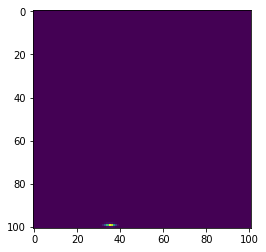

In [9]:
print(Pl.shape)
print(mu.shape)
print(E.shape)
print(E)

l = 101
a = np.array([np.linspace(0,1,l),
              np.linspace(0,1,l)])
pl = np.empty((len(inputs[0]), len(a[0]), len(a[1]))) #dim 3xlxl
# print(pl.shape)

# calc
pl[0,:,:] = G2D(a, mu[:,0], E[0])*Pl[0]
pl[1,:,:] = G2D(a, mu[:,1], E[1])*Pl[1]
pl[2,:,:] = G2D(a, mu[:,2], E[2])*Pl[2]
# print(pl[0,:,:])
im = np.sum(pl, axis = 0)
plt.imshow(im)
# plt.imshow(pl[2])

In [ ]:
plt.imshow(pl[0,:,:])